In [1]:
import datetime
print(datetime.datetime.today())

2023-11-12 16:35:44.975255


In [2]:
import tensorflow as tf
tf.__version__

2023-11-12 16:35:55.509474: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 16:35:58.321529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-12 16:35:58.321572: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-12 16:35:58.322911: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-12 16:35:59.713057: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 16:35:59.717518: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

'2.14.0'

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2023-11-11 22:49:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.221.155, 34.101.5.123, 142.251.223.59, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.221.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.47M  4.24MB/s    in 27s     

2023-11-11 22:49:28 (3.81 MB/s) - ‘pizza_steak.zip.1’ saved [109540975/109540975]



In [5]:
import zipfile
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

In [3]:
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.


In [4]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train 


750

In [5]:
import pathlib
import numpy as np

data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a python path
class_name = np.array(sorted([item.name for item in data_dir.glob('*')])) # membuat list nama kelas dari nama subfolder di folder train
print(class_name)

['pizza' 'steak']


🤔 Note: Whenever you're working with data, it's always good to visualize it as much as possible. Treat your first couple of steps of a project as becoming one with the data. Visualize, visualize, visualize.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # setup target directory 
    target_folder = target_dir+target_class
    
    # get random image path 
    random_image = random.sample(os.listdir(target_folder),1)
    # read image and plot with matplotlib
    img = mpimg.imread(target_folder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    
    print(f"image shape {img.shape}")
    return img


image shape (512, 382, 3)


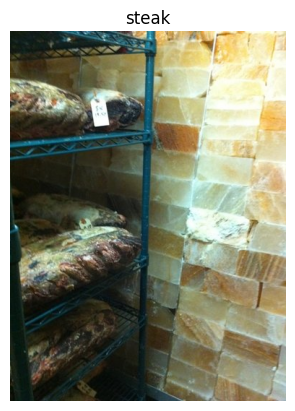

In [7]:
img = view_random_image(target_dir='pizza_steak/train/',
                        target_class='steak'
                        )

In [8]:
img/255

array([[[0.08235294, 0.11372549, 0.0627451 ],
        [0.08627451, 0.11764706, 0.06666667],
        [0.08235294, 0.11372549, 0.0627451 ],
        ...,
        [0.92156863, 0.90588235, 0.72941176],
        [0.91764706, 0.88235294, 0.71372549],
        [0.91372549, 0.88235294, 0.70196078]],

       [[0.08235294, 0.11372549, 0.0627451 ],
        [0.09019608, 0.12156863, 0.07058824],
        [0.08235294, 0.11372549, 0.0627451 ],
        ...,
        [0.92941176, 0.90196078, 0.72941176],
        [0.90980392, 0.87843137, 0.69803922],
        [0.90196078, 0.87058824, 0.68627451]],

       [[0.07058824, 0.10980392, 0.06666667],
        [0.0745098 , 0.11372549, 0.07058824],
        [0.06666667, 0.10588235, 0.0627451 ],
        ...,
        [0.91764706, 0.89411765, 0.70588235],
        [0.90196078, 0.87058824, 0.67843137],
        [0.89803922, 0.85882353, 0.66666667]],

       ...,

       [[0.05098039, 0.0627451 , 0.02745098],
        [0.05490196, 0.06666667, 0.03137255],
        [0.05098039, 0

📖 Resource: The architecture we're using below is a scaled-down version of VGG-16, a convolutional neural network which came 2nd in the 2014 ImageNet classification competition.

In [9]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# set seed
tf.random.set_seed(42)

# preprocess data with normalization
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# train and test directory
train_dir = "pizza_steak/train/"
valid_dir = "pizza_steak/test/"

# import data and turn into batches
train_data = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224,224),
    class_mode='binary',
    seed=42
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    batch_size=32,
    target_size=(224,224),
    class_mode='binary',
    seed=42
)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            filters=10,
            kernel_size=3, # (3x3),
            activation='relu',
            input_shape=(224,224,3)
        ),
        tf.keras.layers.Conv2D(
            filters=10,
            kernel_size=3,
            activation=tf.keras.layers.Activation(tf.nn.relu)
        ),
        tf.keras.layers.MaxPool2D(
            pool_size=2, # (2x2)
            padding='valid' 
        ),
        tf.keras.layers.Conv2D(
            filters=10,
            kernel_size=(3,3),
            activation='relu'
        ),
        tf.keras.layers.Conv2D(
            filters=10,
            kernel_size=(3,3),
            activation=tf.keras.layers.Activation(tf.nn.relu)
        ),
        tf.keras.layers.MaxPool2D(
            pool_size=(2,2)
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            1,
            activation='sigmoid' # binary activation sigmoid
        )
    ]
)

# compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# fit Model
history = model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 36s 708ms/step - loss: 0.5579 - accuracy: 0.7127 - val_loss: 0.4527 - val_accuracy: 0.8080
Epoch 2/5
47/47 [==============================] - 29s 606ms/step - loss: 0.4529 - accuracy: 0.7787 - val_loss: 0.3661 - val_accuracy: 0.8580
Epoch 3/5
47/47 [==============================] - 28s 601ms/step - loss: 0.4091 - accuracy: 0.8200 - val_loss: 0.3557 - val_accuracy: 0.8520
Epoch 4/5
47/47 [==============================] - 27s 579ms/step - loss: 0.3668 - accuracy: 0.8440 - val_loss: 0.3284 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 28s 593ms/step - loss: 0.3037 - accuracy: 0.8833 - val_loss: 0.3383 - val_accuracy: 0.8460


In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

# Using the same model as before

In [3]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(
        input_shape=(224,244,3)
    ),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history2 = model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)


Epoch 1/5
47/47 [==============================] - 27s 576ms/step - loss: 0.3198 - accuracy: 0.8667 - val_loss: 0.3670 - val_accuracy: 0.8380
Epoch 2/5
47/47 [==============================] - 27s 574ms/step - loss: 0.2610 - accuracy: 0.9047 - val_loss: 0.3542 - val_accuracy: 0.8400
Epoch 3/5
47/47 [==============================] - 27s 571ms/step - loss: 0.2220 - accuracy: 0.9193 - val_loss: 0.4478 - val_accuracy: 0.8200
Epoch 4/5
47/47 [==============================] - 27s 572ms/step - loss: 0.1769 - accuracy: 0.9300 - val_loss: 0.6837 - val_accuracy: 0.7500
Epoch 5/5
47/47 [==============================] - 27s 573ms/step - loss: 0.1610 - accuracy: 0.9447 - val_loss: 0.5844 - val_accuracy: 0.7920


In [7]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 163968)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 655876    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 655901 (2.50 MB)
Trainable params: 655901 (2.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(
        input_shape=(224,224,3),
    ),
    tf.keras.layers.Dense(
        100,
        activation='relu'
    ),
    tf.keras.layers.Dense(
        100,
        activation='relu'
    ),
    tf.keras.layers.Dense(
        100,
        activation='relu'
    ),
    tf.keras.layers.Dense(
        1,
        activation='sigmoid'
    )
])

model3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history3 = model3.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 1/5
47/47 [==============================] - 9s 167ms/step - loss: 4.0506 - accuracy: 0.6047 - val_loss: 0.7613 - val_accuracy: 0.7660
Epoch 2/5
47/47 [==============================] - 8s 161ms/step - loss: 0.8853 - accuracy: 0.7093 - val_loss: 0.5222 - val_accuracy: 0.7780
Epoch 3/5
47/47 [==============================] - 8s 161ms/step - loss: 0.7045 - accuracy: 0.7213 - val_loss: 1.3760 - val_accuracy: 0.6040
Epoch 4/5
47/47 [==============================] - 8s 163ms/step - loss: 0.6734 - accuracy: 0.7420 - val_loss: 0.5966 - val_accuracy: 0.7120
Epoch 5/5
47/47 [==============================] - 8s 162ms/step - loss: 0.5701 - accuracy: 0.7560 - val_loss: 0.6687 - val_accuracy: 0.7720


In [14]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 150528)            0         
                                                                 
 dense_24 (Dense)            (None, 100)               15052900  
                                                                 
 dense_25 (Dense)            (None, 100)               10100     
                                                                 
 dense_26 (Dense)            (None, 100)               10100     
                                                                 
 dense_27 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15073201 (57.50 MB)
Trainable params: 15073201 (57.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


image shape (512, 512, 3)
image shape (342, 512, 3)


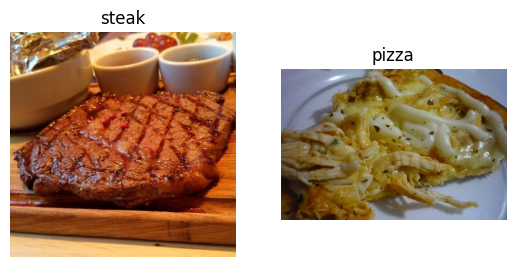

In [29]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

In [34]:
images, labels = train_data.next()
images[1],labels[1], len(images), len(labels)

(array([[[0.02745098, 0.00392157, 0.01176471],
         [0.02352941, 0.        , 0.01568628],
         [0.05490196, 0.01176471, 0.02745098],
         ...,
         [0.13333334, 0.0627451 , 0.05490196],
         [0.1137255 , 0.04313726, 0.03529412],
         [0.1254902 , 0.05490196, 0.04705883]],
 
        [[0.01568628, 0.00784314, 0.01176471],
         [0.00784314, 0.        , 0.00392157],
         [0.03137255, 0.00784314, 0.02352941],
         ...,
         [0.12156864, 0.0509804 , 0.04313726],
         [0.13333334, 0.0627451 , 0.05490196],
         [0.1254902 , 0.05490196, 0.04705883]],
 
        [[0.00392157, 0.01176471, 0.        ],
         [0.        , 0.00784314, 0.00392157],
         [0.        , 0.00784314, 0.00392157],
         ...,
         [0.1254902 , 0.05490196, 0.04705883],
         [0.11764707, 0.04705883, 0.03921569],
         [0.1254902 , 0.05490196, 0.04705883]],
 
        ...,
 
        [[0.58431375, 0.6627451 , 0.7058824 ],
         [0.5803922 , 0.65882355, 0.70196

In [36]:
history.history

{'loss': [0.6487322449684143,
  0.4787669777870178,
  0.47406718134880066,
  0.42799848318099976,
  0.35794565081596375],
 'accuracy': [0.6553333401679993,
  0.7846666574478149,
  0.7799999713897705,
  0.8086666464805603,
  0.8579999804496765],
 'val_loss': [0.4783424735069275,
  0.44234713912010193,
  0.38794010877609253,
  0.34749022126197815,
  0.3661735951900482],
 'val_accuracy': [0.7839999794960022,
  0.7960000038146973,
  0.8339999914169312,
  0.8659999966621399,
  0.8360000252723694]}

<Axes: >

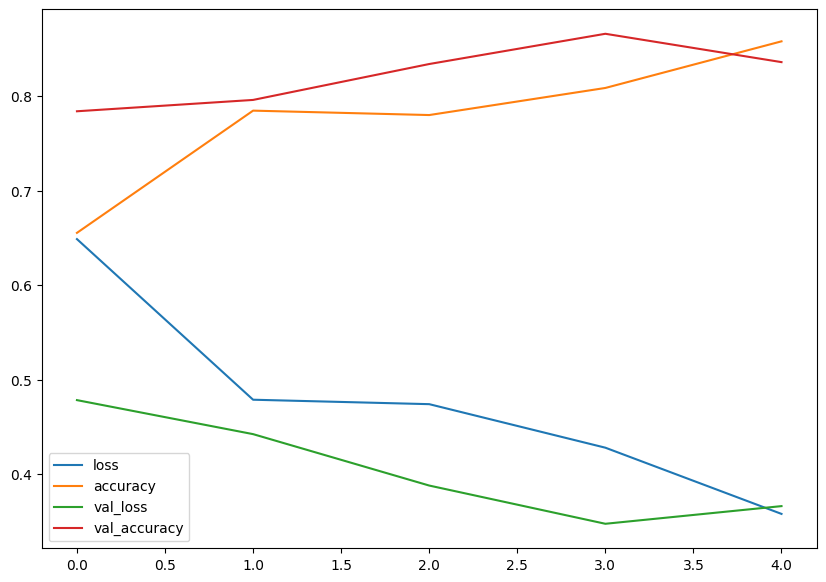

In [42]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(10,7))

## Note: When a model's validation loss starts to increase, it's likely that it's overfitting the training dataset. This means, it's learning the patterns in the training dataset too well and thus its ability to generalize to unseen data will be diminished.

In [38]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.648732,0.655333,0.478342,0.784
1,0.478767,0.784667,0.442347,0.796
2,0.474067,0.780000,0.387940,0.834
3,0.427998,0.808667,0.347490,0.866
4,0.357946,0.858000,0.366174,0.836


In [12]:
def plot_loss_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # plot loss
    plt.plot(epochs, loss, label="Training loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel('Epochs')
    plt.legend()
    
    # plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="Accuracy")
    plt.plot(epochs, val_acc, label='Val_acc')
    plt.xlabel('epochs')
    plt.title('Accuracy')
    plt.legend()

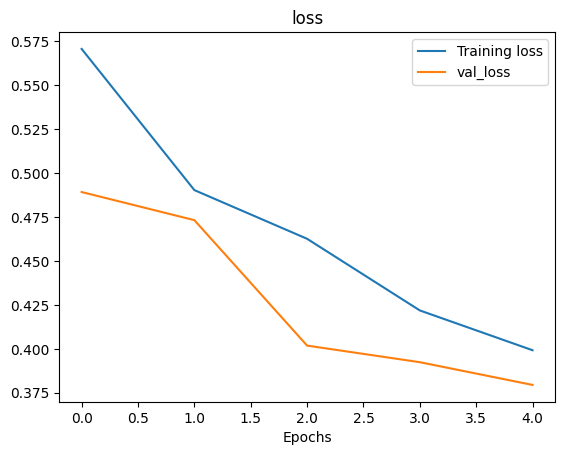

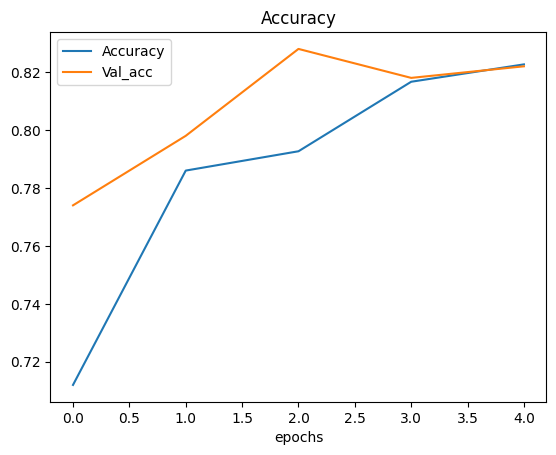

In [13]:
plot_loss_curve(history5)

In [47]:
model4 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            filters = 10,
            kernel_size = 3,
            strides = 1,
            padding = 'valid',
            activation = 'relu',
            input_shape = (224,224,3)
        ),
        tf.keras.layers.Conv2D(
            filters=10,
            kernel_size=3,
            activation='relu'
        ),
        tf.keras.layers.Conv2D(
            filters=10,
            kernel_size=3,
            activation='relu'
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

model4.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history4 = model4.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=5,
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 1/5
47/47 [==============================] - 35s 723ms/step - loss: 1.0428 - accuracy: 0.5380 - val_loss: 0.5723 - val_accuracy: 0.6620
Epoch 2/5
47/47 [==============================] - 34s 720ms/step - loss: 0.4559 - accuracy: 0.8033 - val_loss: 0.3785 - val_accuracy: 0.8220
Epoch 3/5
47/47 [==============================] - 34s 724ms/step - loss: 0.3552 - accuracy: 0.8513 - val_loss: 0.3710 - val_accuracy: 0.8420
Epoch 4/5
47/47 [==============================] - 34s 722ms/step - loss: 0.1838 - accuracy: 0.9453 - val_loss: 0.3965 - val_accuracy: 0.8340
Epoch 5/5
47/47 [==============================] - 34s 717ms/step - loss: 0.0657 - accuracy: 0.9847 - val_loss: 0.3974 - val_accuracy: 0.8280


In [50]:
model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_8 (Flatten)         (None, 475240)            0         
                                                                 
 dense_28 (Dense)            (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model5 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            filters=10,
            input_shape=(224,224,3),
            kernel_size=3,
            activation='relu'
        ),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.Conv2D(filters=10, kernel_size=3),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(filters=10, kernel_size=3),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

model5.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

history5 = model5.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 1/5
47/47 [==============================] - 13s 245ms/step - loss: 0.5704 - accuracy: 0.7120 - val_loss: 0.4891 - val_accuracy: 0.7740
Epoch 2/5
47/47 [==============================] - 11s 233ms/step - loss: 0.4902 - accuracy: 0.7860 - val_loss: 0.4731 - val_accuracy: 0.7980
Epoch 3/5
47/47 [==============================] - 11s 235ms/step - loss: 0.4625 - accuracy: 0.7927 - val_loss: 0.4018 - val_accuracy: 0.8280
Epoch 4/5
47/47 [==============================] - 11s 236ms/step - loss: 0.4218 - accuracy: 0.8167 - val_loss: 0.3924 - val_accuracy: 0.8180
Epoch 5/5
47/47 [==============================] - 11s 233ms/step - loss: 0.3992 - accuracy: 0.8227 - val_loss: 0.3795 - val_accuracy: 0.8220


## Data augmentation

In [28]:
train_datagen_augmentation = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_augmen = train_datagen_augmentation.flow_from_directory(
    train_dir,
    class_mode='binary',
    target_size=(224,224),
    shuffle=True,
    batch_size=32
)


Found 1500 images belonging to 2 classes.


In [16]:
image, label = train_data.next()
aug_image, aug_label = train_augmen.next()

(-0.5, 223.5, 223.5, -0.5)

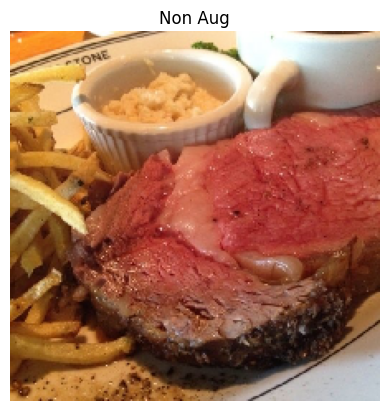

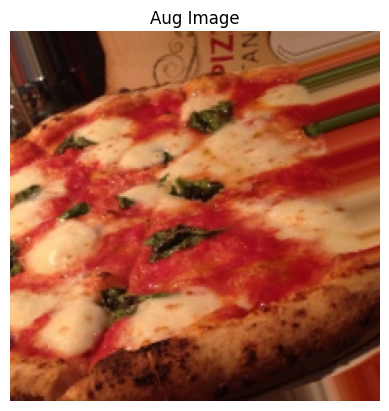

In [25]:
random_number = random.randint(0,32)
plt.imshow(image[random_number])
plt.title("Non Aug")
plt.axis(False)
plt.figure()
plt.imshow(aug_image[random_number])
plt.title("Aug Image")
plt.axis(False)

In [29]:
model6 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            input_shape=(224,224,3),
            kernel_size=3,
            filters=10,
            activation='relu'
        ),
        tf.keras.layers.MaxPool2D(
            pool_size=(2,2),
        ),
        tf.keras.layers.Conv2D(
            kernel_size=3,
            filters=10
        ),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(
            kernel_size=3,
            filters=10
        ),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

model6.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history6 = model6.fit(
    train_augmen,
    epochs=5,
    steps_per_epoch=len(train_augmen),
    validation_steps=len(valid_data),
    validation_data=valid_data
)


Epoch 1/5
47/47 [==============================] - 19s 375ms/step - loss: 0.6456 - accuracy: 0.6147 - val_loss: 0.5286 - val_accuracy: 0.7440
Epoch 2/5
47/47 [==============================] - 18s 371ms/step - loss: 0.5718 - accuracy: 0.7140 - val_loss: 0.4362 - val_accuracy: 0.8040
Epoch 3/5
47/47 [==============================] - 17s 369ms/step - loss: 0.5165 - accuracy: 0.7513 - val_loss: 0.4229 - val_accuracy: 0.8100
Epoch 4/5
47/47 [==============================] - 17s 370ms/step - loss: 0.5186 - accuracy: 0.7420 - val_loss: 0.3861 - val_accuracy: 0.8240
Epoch 5/5
47/47 [==============================] - 18s 372ms/step - loss: 0.4939 - accuracy: 0.7600 - val_loss: 0.3734 - val_accuracy: 0.8600


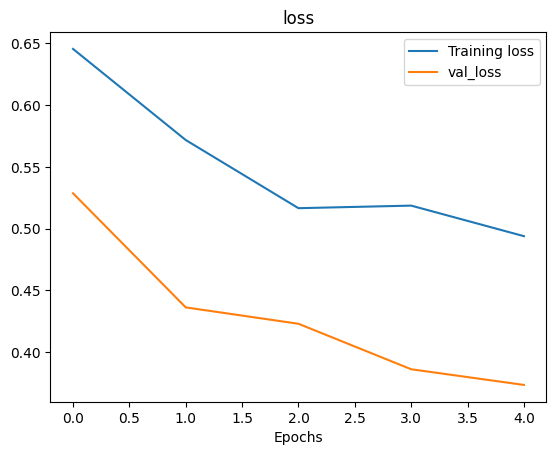

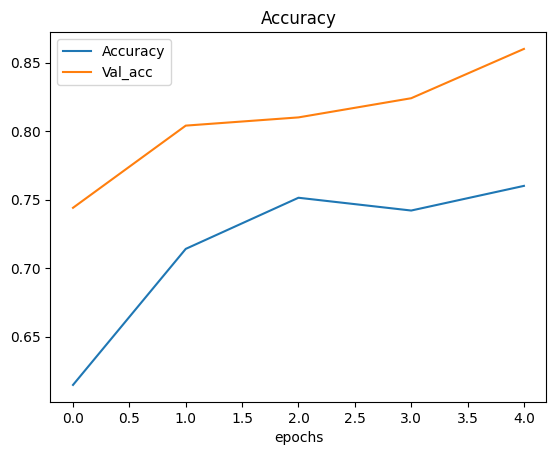

In [30]:
plot_loss_curve(history6)

## Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )

In [33]:
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
model7 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            filters=10,
            kernel_size=3,
            input_shape=(224,224,3),
            activation='relu'
        ),
        tf.keras.layers.Conv2D(
            filters=10,
            kernel_size=3,
            activation='relu'
        ),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(
            filters=10,
            kernel_size=3,
            activation='relu'
        ),
        tf.keras.layers.Conv2D(
            filters=10,
            kernel_size=3,
            activation='relu'
        ),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

model7.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history7 = model7.fit(
    train_augmen,
    epochs=20,
    steps_per_epoch=len(train_augmen),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 1/20
47/47 [==============================] - 29s 588ms/step - loss: 0.6265 - accuracy: 0.6673 - val_loss: 0.4672 - val_accuracy: 0.7960
Epoch 2/20
47/47 [==============================] - 28s 584ms/step - loss: 0.5441 - accuracy: 0.7400 - val_loss: 0.4243 - val_accuracy: 0.8420
Epoch 3/20
47/47 [==============================] - 28s 588ms/step - loss: 0.5393 - accuracy: 0.7460 - val_loss: 0.4364 - val_accuracy: 0.7960
Epoch 4/20
47/47 [==============================] - 28s 588ms/step - loss: 0.5067 - accuracy: 0.7660 - val_loss: 0.3744 - val_accuracy: 0.8540
Epoch 5/20
47/47 [==============================] - 28s 592ms/step - loss: 0.5148 - accuracy: 0.7653 - val_loss: 0.4329 - val_accuracy: 0.8060
Epoch 6/20
47/47 [==============================] - 28s 589ms/step - loss: 0.4914 - accuracy: 0.7773 - val_loss: 0.3774 - val_accuracy: 0.8380
Epoch 7/20
47/47 [==============================] - 28s 588ms/step - loss: 0.4667 - accuracy: 0.7760 - val_loss: 0.3536 - val_accuracy: 0.8600

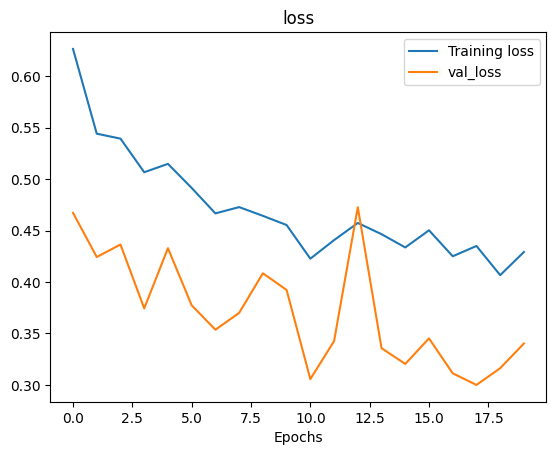

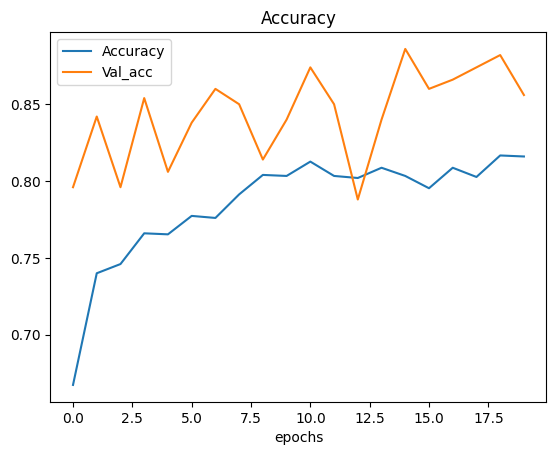

In [34]:
plot_loss_curve(history7)

--2023-11-12 18:41:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  4.03MB/s    in 0.5s    

2023-11-12 18:41:43 (4.03 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



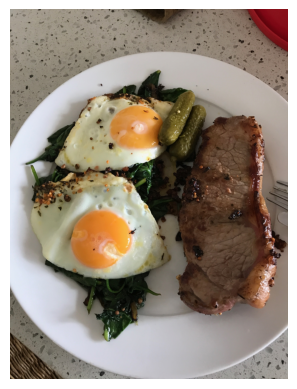

In [35]:
# View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [36]:
steak.shape

(4032, 3024, 3)

In [37]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
    """
      Reads an image from filename, turns it into a tensor
      and reshapes it to (img_shape, img_shape, colour_channel).
    """
    
    # read in target file (an image)
    img = tf.io.read_file(filename)
    
    # Decode the read file into a tensor & ensure 3 colour channels 
    # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
    img = tf.image.decode_image(img, channels=3)
    
    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size=[img_shape, img_shape])
    
    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img
    

In [38]:
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

There's one more problem...

Although our image is in the same shape as the images our model has been trained on, we're still missing a dimension.

Remember how our model was trained in batches?

Well, the batch size becomes the first dimension.

So in reality, our model was trained on data in the shape of (batch_size, 224, 224, 3).

We can fix this by adding an extra to our custom image tensor using tf.expand_dims.


In [39]:
steak_ = tf.expand_dims(steak, axis=0)
steak.shape, steak_.shape

(TensorShape([224, 224, 3]), TensorShape([1, 224, 224, 3]))

In [41]:
pred = model7.predict(steak_)
pred

1/1 [==============================] - 0s 18ms/step


array([[0.7750757]], dtype=float32)

In [42]:
pred_class = class_name[int(tf.round(pred)[0][0])]
pred_class

'steak'